In [1]:
!pip install --upgrade jupyter_client
from loadfunctions import *
from PIL import Image
import os, sys, glob
import fnmatch
import numpy as np
import tensorflow as tf
import random
from IPython.display import clear_output

a=1


In [2]:
all_images,src_images,resized_images= get_image_lists()   
print(len(all_images))
print(len(src_images))
print(len(resized_images))
print(src_images[0])
np_images_list = resize(src_images,128,int(128*.75))


198
99
99
/home/jovyan/work/nasa_planet_dataset/1019.jpg


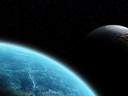

In [3]:
np_images_list[0].shape
tf.keras.preprocessing.image.array_to_img(np_images_list[0]).show()

(594, 96, 128, 3)
(96, 128, 3)


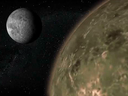

(535, 96, 128, 3) (59, 96, 128, 3)


In [4]:

np_images = np.array(np_images_list,dtype='float16',ndmin=(4))
np_images = easy_training_aug(np_images)
np.random.shuffle( np_images)
print(np_images.shape)
print(np_images[0].shape)
tf.keras.preprocessing.image.array_to_img(np_images[0]).show()

test_num = int(len(np_images)*.1)
X = np_images[0:-test_num]
X_test = np_images[-test_num:]

print(X.shape,X_test.shape)

2022-06-25 02:09:53.528755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-25 02:09:53.535293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-25 02:09:53.535836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-25 02:09:53.536460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 25, 128)       9728      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 12, 160)        82080     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 6, 192)         123072    
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1152)              5309568   
_________________________________________________________________
reshape (Reshape)            (None, 6, 8, 24)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 16, 256)       2

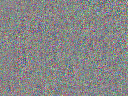

In [5]:
def my_conv2dtrans(in_size,out_size,stride_size,filters=64):
    ## if Padding == Valid;
    ## HO = (HI-1) * stride + HF
    ## stride = (HO-HF)/(HI-1) 
    ## HF = -(HI)(stride)+(stride)+HO
    
    f_size = -in_size*stride_size+stride_size+out_size
    return tf.keras.layers.Conv2DTranspose(filters,f_size,stride_size)
    
def get_trans():
    f=8
    
    trans = tf.keras.Sequential()
    trans.add(tf.keras.layers.Conv2D(96+32,5,5,input_shape = (96,128,3)))
    trans.add(tf.keras.layers.Conv2D(96+64,2,2))
    trans.add(tf.keras.layers.Conv2D(128+64,2,2))
    
    trans.add(tf.keras.layers.Flatten())

    trans.add(tf.keras.layers.Dense((128*96*3)/32,activation="linear"))    
#    trans.add(tf.keras.layers.Dense(48*4,activation="linear"))    
#    trans.add(tf.keras.layers.Dense(48*8,activation="linear"))    
#   trans.add(tf.keras.layers.Dense(48*16,activation="linear"))    
    
    trans.add(tf.keras.layers.Reshape((6,8,-1)))
    
    ## Padding==Valid H = (HI-1) * stride + HF
    
    
    trans.add(my_conv2dtrans(8,16,2,256)) 
    trans.add(my_conv2dtrans(16,32,2,128)) 
    trans.add(my_conv2dtrans(32,64,2,64))     
    trans.add(my_conv2dtrans(64,128,2,3)) 
    
    
    #trans.add(tf.keras.layers.Conv2DTranspose(64,(4,4),(2,2)))
    #trans.add(tf.keras.layers.Conv2DTranspose(64,(4,4),(2,2)))
    #trans.add(tf.keras.layers.Conv2DTranspose(64,(3,3),(2,2)))
    
    
    
   


    trans.add(tf.keras.layers.Reshape((96,128,3)))
    return trans

fc_trans = get_trans()

out = fc_trans(np_images)
fc_trans.summary()
print(np_images[0].shape)

print(out.shape)
pil_img = tf.keras.preprocessing.image.array_to_img(out[0])
pil_img               


In [6]:
fc_trans.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),loss=tf.keras.losses.MSE)

In [7]:
fc_trans = tf.keras.models.load_model("kt-1")
LR = fc_trans.optimizer.learning_rate
print(LR)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR*.1)
loss = tf.keras.losses.MSE

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001751>


In [8]:
fc_trans = tf.keras.Sequential.from_config(fc_trans.get_config())
fc_trans.compile(optimizer,loss,metrics="MSE")
fc_trans.summary()
a= fc_trans.layers[-1]
fc_trans.pop()
#print(fc_trans.summary())
#print(a)
fc_trans.add(a)
#print(fc_trans.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
squeeze_in (Dense)           (None, 128)               4718720   
_________________________________________________________________
1..368..47360 (Dense)        (None, 368)               47472     
_________________________________________________________________
2..128..47104 (Dense)        (None, 128)               47232     
_________________________________________________________________
3..2408..310528 (Dense)      (None, 2408)              310632    
_________________________________________________________________
4..129..310528 (Dense)       (None, 129)               310761    
_________________________________________________________________
5..170..22059 (Dense)        (None, 170)               2

In [13]:
from multiprocessing import Process,Queue
#from multiprocessing.queues import  SimpleQueue as Queue
def epoch(LQ: Queue):
    while True:
        a=""
        LQ.put(a)
        LQ.task_done()
    return
    a=fc_trans.fit(np_images.astype("float16"),
                       np_images.astype("float16"),
                       validation_data=(X_test,X_test),
                       validation_steps=1,
                       epochs=1,
                       batch_size=batch_size,
                       verbose=1
                  )

In [44]:
import importlib
import trainer
importlib.reload(trainer)

trainer


<module 'trainer' from '/home/jovyan/work/nasa_planet_dataset/trainer.py'>

In [45]:
for cycle in range (50):
    pattern1 = [256,128,64,32,16]    
    pattern2 = [256,128,64,32,16]
    pattern2.reverse()
    pattern = pattern1 + pattern2
    Q = Queue()
    for batch_size in pattern:        
        for epoch in range(1):                        
            epoch_proc = Process(target=trainer.epoch,args=(Q,locals()))
            epoch_proc.start()
            print(1)
            a=Q.get()
            print(2)
            epoch_proc.join()
        if a:  
            clear_output(wait=True)
            pick = random.randint(0,len(np_images)-1)
            tf.keras.preprocessing.image.array_to_img(np_images[pick]).show()        
            out = fc_trans(np_images[pick].reshape((-1,96,128,3)))
            tf.keras.preprocessing.image.array_to_img(out[0]).show()

            print(cycle,batch_size,a["loss"],a.history["val_loss"])

Process Process-24:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/work/nasa_planet_dataset/trainer.py", line 18, in epoch
    a = fc_trans.fit(np_images.astype("float16"),
  File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1105, in fit
    version_utils.disallow_legacy_graph('Model', 'fit')
  File "/opt/conda/lib/python3.9/site-packages/keras/utils/version_utils.py", line 129, in disallow_legacy_graph
    raise ValueError(error_msg)
ValueError: Calling `Model.fit` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.fit` with eager mode enabled.


1


KeyboardInterrupt: 

In [ ]:

pil_img = tf.keras.preprocessing.image.array_to_img(np_images[0][0])
pil_img               

In [ ]:
out = fc_trans(np_images[10])
pil_img = tf.keras.preprocessing.image.array_to_img(out[0])
pil_img               

In [ ]:
import ipywidgets as widgets
widgets.IntSlider()